# Adversarial example on MNIST

### [tensorflow/cleverhans](https://github.com/tensorflow/cleverhans)

#### This jupyter is for practicing hand-crafting adversarial example, the implementation was referenced from tensorflow mnist tutorial & cleverhans.



## Basic Import & Settings

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import tensorflow as tf
import numpy as np
from tqdm import tqdm_notebook as tqdm

import seaborn as sns
import matplotlib.pyplot as plt
from ipywidgets import interact
import math
%matplotlib inline

/Users/lo.chenchou/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sns.set_style('white')
colors_list = sns.color_palette("Paired", 10)
SEED = 1984
np.random.seed(SEED)
tf.set_random_seed(SEED)

In [3]:
mnist = input_data.read_data_sets('./', one_hot=True)

Extracting ./train-images-idx3-ubyte.gz
Extracting ./train-labels-idx1-ubyte.gz
Extracting ./t10k-images-idx3-ubyte.gz
Extracting ./t10k-labels-idx1-ubyte.gz


In [4]:
# To run nicely in jupyter notebook
sess = tf.InteractiveSession()

In [5]:
# Functions for creating weights and biases
# https://www.tensorflow.org/get_started/mnist/pros
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

# Functions for convolution and pooling functions
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

def max_pooling_2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

## Build Model Graph

In [6]:
# Create placeholders nodes for images and label inputs
x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [7]:
# Build model graph

# Input layer
x_image = tf.reshape(x, [-1,28,28,1]) # mnist image comes in as 784 vector

# Conv 1 
W_conv1 = weight_variable([3, 3, 1, 32])
b_conv1 = bias_variable([32])
x_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
x_pool1 = max_pooling_2x2(x_conv1)

# Conv 2
W_conv2 = weight_variable([3, 3, 32, 64])
b_conv2 = bias_variable([64])
x_conv2 = tf.nn.relu(conv2d(x_pool1, W_conv2) + b_conv2)
x_pool2 = max_pooling_2x2(x_conv2)

# Conv 3
W_conv3 = weight_variable([3, 3, 64, 128])
b_conv3 = bias_variable([128])
x_conv3 = tf.nn.relu(conv2d(x_pool2, W_conv3) + b_conv3)
x_pool3 = max_pooling_2x2(x_conv3)

# Flatten
shape = x_pool3.get_shape().as_list()
x_flat = tf.reshape(x_pool3, [-1, np.prod(shape[1:])])

# FC 
W_fc1 = weight_variable([np.prod(shape[1:]), 784])
b_fc1 = bias_variable([784])
x_fc1 = tf.nn.relu(tf.matmul(x_flat, W_fc1) + b_fc1)

# dropout
keep_prob = tf.placeholder(tf.float32)
x_fc1_drop = tf.nn.dropout(x_fc1, keep_prob)

# output
W_fc2 = weight_variable([784, 10])
b_fc2 = bias_variable([10])
y_conv = tf.matmul(x_fc1_drop, W_fc2) + b_fc2
y_pred = tf.nn.softmax(y_conv)

In [8]:
# Loss and optimizer
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

# Accuracy
correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [9]:
# Initilize all global variables
sess.run(tf.global_variables_initializer())

## Start Training Model

In [10]:
# Train model
train_accuracies = []
train_losses = []
epochs = 701
for i in tqdm(range(epochs)):
    batch = mnist.train.next_batch(100)
    train_accuracy = accuracy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0})
    train_accuracies.append(train_accuracy)
    
    train_loss = (cross_entropy.eval(feed_dict={x:batch[0], y_: batch[1], keep_prob: 1.0}))
    train_losses.append(train_loss)
    
    if i % 50 == 0:
        print('step {:3d}, training acc {:.3f}, loss {:.3f}'.format(i, train_accuracy, train_loss))

    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.4})

A Jupyter Widget

step   0, training acc 0.090, loss 8.872
step  50, training acc 0.590, loss 1.347
step 100, training acc 0.820, loss 0.864
step 150, training acc 0.870, loss 0.642
step 200, training acc 0.840, loss 0.550
step 250, training acc 0.880, loss 0.499
step 300, training acc 0.900, loss 0.348
step 350, training acc 0.950, loss 0.233
step 400, training acc 0.960, loss 0.204
step 450, training acc 0.900, loss 0.332
step 500, training acc 0.920, loss 0.315
step 550, training acc 0.950, loss 0.245
step 600, training acc 0.960, loss 0.163
step 650, training acc 0.950, loss 0.142
step 700, training acc 0.930, loss 0.174



In [11]:
print("Test accuracy on test images: %g" % accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))


Test accuracy on test images: 0.9489


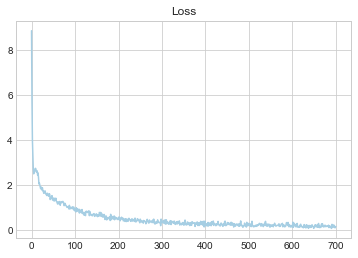

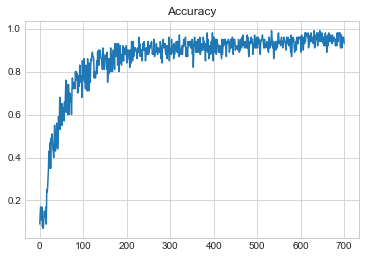

In [12]:
sns.set_style('whitegrid')
accuracy_history = np.array(train_accuracies)
loss_history = np.array(train_losses)

plt.figure()
plt.title('Loss')
plt.plot(loss_history, color=colors_list[0])

plt.figure()
plt.title('Accuracy')
plt.plot(accuracy_history, color=colors_list[1])


# Create Adversarial Examples

[mnist_tutorial_tf.py](https://github.com/tensorflow/cleverhans/blob/master/cleverhans_tutorials/mnist_tutorial_tf.py)

[attacks.py](https://github.com/tensorflow/cleverhans/blob/master/cleverhans/attacks.py)

[attacks_tf.py](https://github.com/tensorflow/cleverhans/blob/master/cleverhans/attacks_tf.py)

[utils_tf.py](https://github.com/tensorflow/cleverhans/blob/master/cleverhans/utils_tf.py)


In [13]:
def predict(input_image):
    prediction = (y_pred.eval(feed_dict={x: input_image.reshape(1, 784), keep_prob: 1.0}))
    print('Predict Label:', np.argmax(prediction))
    print('Confidence:', np.max(prediction))
    
def predict_all(input_image):
    prediction = (y_pred.eval(feed_dict={x: input_image.reshape(1, 784), keep_prob: 1.0}))
    for i in range(len(prediction[0])):
        print(' {}: {:.4f}'.format(i, prediction[0][i]))

def predict_target(input_image, target_num):
    prediction = (y_pred.eval(feed_dict={x: input_image.reshape(1, 784), keep_prob: 1.0}))
    print('label {}: {:.4f}'.format(target_num, prediction[0][target_num]))

Predict Label: 1
Confidence: 0.7569454
 0: 0.0025
 1: 0.7569
 2: 0.0573
 3: 0.0158
 4: 0.0086
 5: 0.0024
 6: 0.0075
 7: 0.0619
 8: 0.0825
 9: 0.0047


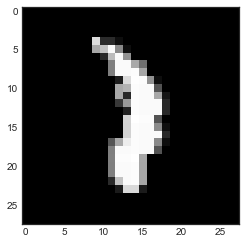

In [14]:
# get image to use
sns.set_style('white')
origin_image = mnist.test.images[2018]
plt.imshow(origin_image.reshape(28,28), interpolation="nearest", cmap="gray", vmin=0, vmax=1)
predict(origin_image)
predict_all(origin_image)

In [15]:
# create label
original_number = 1
original_label = np.zeros(10)
original_label[original_number] = 1

# create target label
target_number = 1
target_label = np.zeros(10)
target_label[target_number] = 1

print('original_label: {}'.format(original_label))
print('target_label:   {}'.format(target_label))

original_label: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
target_label:   [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


#  Steps

### 1. loss = utils_tf.model_loss(y, preds, mean=False)   
        ( tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y) )
### 2. loss = -loss
### 3. grad, = tf.gradients(loss, x)
### 4. normalized_grad = tf.sign(grad)
### 5. scaled_grad = eps * normalized_grad
### 6. adv_x = x + scaled_grad


In [16]:
# 1 compute model_loss
model_loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv)

# 2 if targeted
model_loss = model_loss

# 3 compute gradient
grad = tf.gradients(model_loss, x)

# 4 compute sign(grad)
normalized_grad = tf.sign(grad)

# 5 scale by constant epsilon
eps = 0.3
scaled_grad = eps * normalized_grad


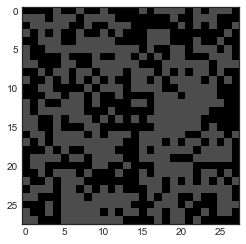

In [17]:
pert_term = scaled_grad.eval(feed_dict={x: origin_image.reshape(1,784), y_: target_label.reshape(1,10), keep_prob: 1.0})
plt.imshow(pert_term.reshape(28, 28), cmap='gray', vmin=0, vmax=1)

label 1: 0.0222
 0: 0.0028
 1: 0.0222
 2: 0.1524
 3: 0.3977
 4: 0.0112
 5: 0.0020
 6: 0.0106
 7: 0.1199
 8: 0.2768
 9: 0.0043


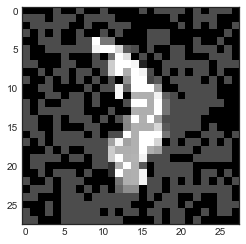

In [18]:
# 6 adv_x = x + scaled_grad
adversarial_example = origin_image + pert_term
plt.imshow(adversarial_example.reshape(28, 28), cmap='gray', vmin=0, vmax=1)
# predict(adversarial_example)
predict_target(adversarial_example, 1)
predict_all(adversarial_example)

### check model_loss before & after

In [40]:
# model_loss
orignial_loss = model_loss.eval(feed_dict={x: origin_image.reshape(1,784), y_: target_label.reshape(1,10), keep_prob: 1.0})
adv_loss = model_loss.eval(feed_dict={x: adversarial_example.reshape(1,784), y_: target_label.reshape(1,10), keep_prob: 1.0})
print('orignial_loss: {}'.format(orignial_loss))
print('adv_loss: {}'.format(adv_loss))

orignial_loss: [-0.27846417]
adv_loss: [-3.8080864]


# More Experiments

In [41]:
original_label = 7
num_mask = 5

index_mask = np.where(mnist.test.labels[:, original_label])[0]
subset_mask = np.random.choice(index_mask, num_mask)
origin_images = mnist.test.images[subset_mask]
origin_labels = mnist.test.labels[subset_mask]

In [42]:
prediction = y_pred.eval(feed_dict={x: origin_images, y_: origin_labels, keep_prob: 1.0})
print('Predictions: {}'.format(np.argmax(prediction,1)))

Predictions: [7 7 7 7 7]


Correct Label: 7
Predict Label: 7
Confidence: 0.9998945


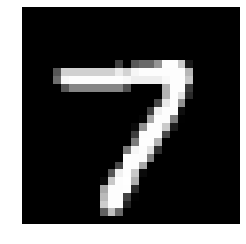

Correct Label: 7
Predict Label: 7
Confidence: 0.9841769


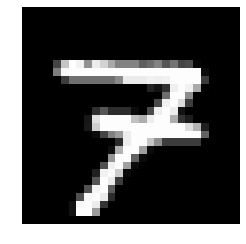

Correct Label: 7
Predict Label: 7
Confidence: 0.99929345


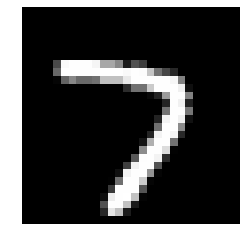

Correct Label: 7
Predict Label: 7
Confidence: 0.9940346


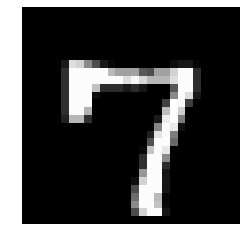

Correct Label: 7
Predict Label: 7
Confidence: 0.99905854


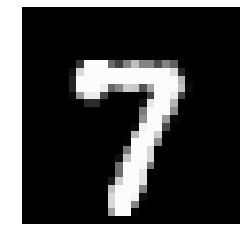

In [43]:
plt.figure()
for i in range(num_mask):
    print('Correct Label:', np.argmax(origin_labels[i]))
    print('Predict Label:', np.argmax(prediction[i]))
    print('Confidence:', np.max(prediction[i]))
    plt.axis('off')
    plt.imshow(origin_images[i].reshape(28,28), interpolation=None, cmap=plt.cm.gray, vmin=0, vmax=1)
    plt.show()

#  Add Random Noise

In [23]:
noisy_imgs = origin_images.copy()
noises = np.random.normal(size=noisy_imgs.size, scale=0.1).reshape(noisy_imgs.shape)
noisy_imgs += noises

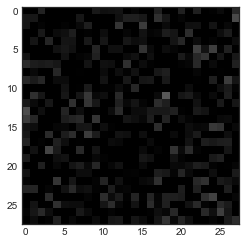

In [24]:
plt.imshow(noises[0].reshape(28,28), interpolation=None, cmap=plt.cm.gray, vmin=0, vmax=1)
plt.show()

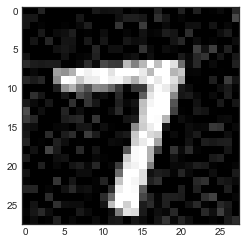

In [25]:
plt.imshow(noisy_imgs[0].reshape(28,28), interpolation=None, cmap=plt.cm.gray, vmin=0, vmax=1)
plt.show()

In [26]:
prediction_n_val = y_pred.eval(feed_dict={x: noisy_imgs, keep_prob: 1.0}, session=sess)
print("predictions", np.argmax(prediction_n_val,1))

predictions [7 7 7 7 7]


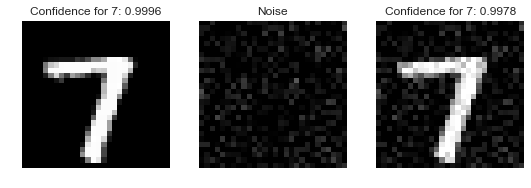

Difference Measure: 7.8035107


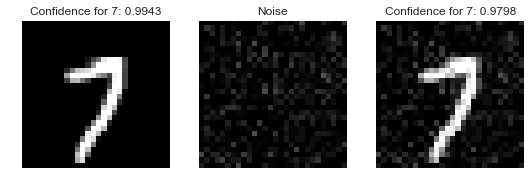

Difference Measure: 8.508473


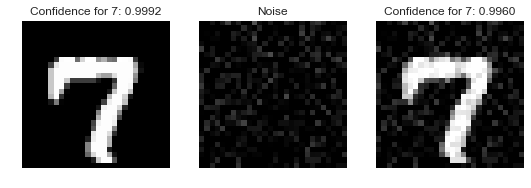

Difference Measure: 7.8516264


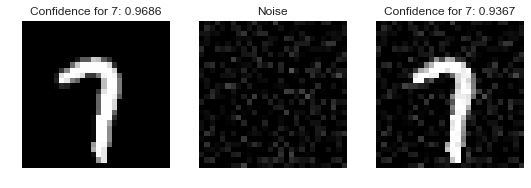

Difference Measure: 7.5513763


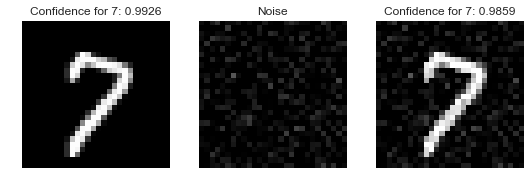

Difference Measure: 7.102448


In [27]:
sns.set_style('white')
for i in range(num_mask):
    fig = plt.figure(figsize=(9, 4))
    
    start_img = origin_images[i,:]
    ax1 = fig.add_subplot(1,3,1)
    ax1.axis('off')
    ax1.imshow(start_img.reshape([28, 28]), interpolation=None, cmap=plt.cm.gray, vmin=0, vmax=1)
    ax1.title.set_text('Confidence for {}: '.format(original_label) + '{:.4f}'.format(prediction[i][original_label]))
    
    noise = noises[i,:]
    ax2 = fig.add_subplot(1,3,2)
    ax2.axis('off')
    ax2.imshow((noise).reshape([28, 28]), interpolation=None, cmap=plt.cm.gray, vmin=0, vmax=1)
    ax2.title.set_text('Noise')
    
    noisy_img = noisy_imgs[i,:]
    ax3 = fig.add_subplot(1,3,3)
    ax3.axis('off')
    ax3.imshow((noisy_img).reshape([28, 28]), interpolation=None, cmap=plt.cm.gray, vmin=0, vmax=1)
    ax3.title.set_text('Confidence for {}: '.format(original_label) + '{:.4f}'.format(prediction_n_val[i][original_label]))
    
    plt.show()
    
    print("Difference Measure:", np.sum((noisy_img - start_img) ** 2))

# Create Adversarial Examples

In [28]:
target_number = 8
target_labels = np.zeros(origin_labels.shape)
target_labels[:, target_number] = 1
print(target_labels)
target_prediction = np.full(num_mask, target_number, dtype=int)
print(target_prediction)

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
[8 8 8 8 8]


In [29]:
# 1 compute model_loss
model_loss = tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv)

# 2 if targeted
model_loss = -model_loss

# 3 compute gradient
grad = tf.gradients(model_loss, x)

# 4 compute sign(grad)
normalized_grad = tf.sign(grad)

# 5 scale by constant epsilon
eps = 0.003
scaled_grad = eps * normalized_grad


In [30]:
iter_num = 501
adversarial_imgs = origin_images.copy()

with sess.as_default():
    for i in range(iter_num):
        pert_term = scaled_grad.eval(feed_dict={x: adversarial_imgs, y_: target_labels, keep_prob: 1.0})
        adversarial_imgs += pert_term.reshape(origin_labels.shape[0], 784)
        prediction_ad = tf.argmax(y_pred,1)
        prediction_ad_val = prediction_ad.eval(feed_dict={x: adversarial_imgs, keep_prob: 1.0}, session=sess)
        accuracy = np.mean(np.equal(prediction_ad_val, np.argmax(origin_labels, 1)))
        if i % 20 == 0:
            print("Iteration {:3}: predictions: {} accuracy: {}".format(i, prediction_ad_val, accuracy))
        
        if np.array_equal(target_prediction, prediction_ad_val):
            print("Iteration {:3}: predictions: {} accuracy: {}".format(i, prediction_ad_val, accuracy))
            break;
            
prediction_ad_val = y_pred.eval(feed_dict={x: adversarial_imgs, keep_prob: 1.0}, session=sess)

Iteration   0: predictions: [7 7 7 7 7] accuracy: 1.0
Iteration  20: predictions: [7 7 7 7 7] accuracy: 1.0
Iteration  36: predictions: [8 8 8 8 8] accuracy: 0.0


target_number: 8


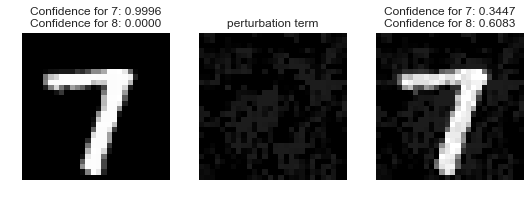

Difference Measure: 4.448312


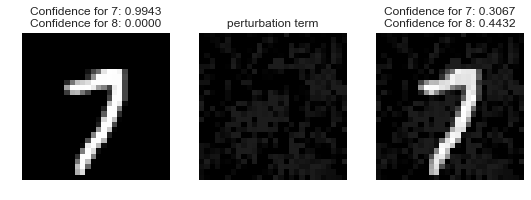

Difference Measure: 4.3091326


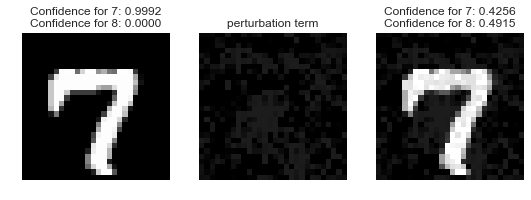

Difference Measure: 4.637459


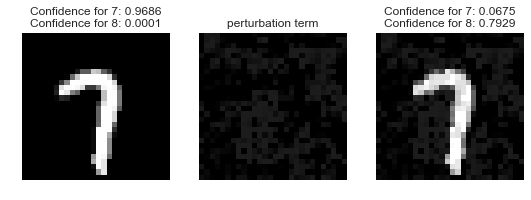

Difference Measure: 4.497485


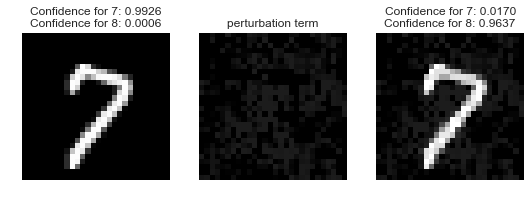

Difference Measure: 4.41015


In [31]:
print('target_number: {}'.format(target_number))
sns.set_style('white')
for i in range(num_mask):
    fig = plt.figure(figsize=(9, 4))
    
    start_img = origin_images[i,:]
    ax1 = fig.add_subplot(1,3,1)
    ax1.axis('off')
    ax1.imshow(start_img.reshape([28, 28]), interpolation=None, cmap=plt.cm.gray, vmin=0, vmax=1)
    ax1.title.set_text('Confidence for {}: '.format(original_label) + '{:.4f}'.format(prediction[i][original_label]) 
                       + '\nConfidence for {}: '.format(target_number) 
                       + '{:.4f}'.format(prediction[i][target_number]))
    
    adversarial_img = adversarial_imgs[i,:]
    ax2 = fig.add_subplot(1,3,2)
    ax2.axis('off')
    ax2.imshow((adversarial_img - start_img).reshape([28, 28]), interpolation=None, cmap=plt.cm.gray, vmin=0, vmax=1)
    ax2.title.set_text('perturbation term')
    
    ax3 = fig.add_subplot(1,3,3)
    ax3.axis('off')
    ax3.imshow((adversarial_img).reshape([28, 28]), interpolation=None, cmap=plt.cm.gray, vmin=0, vmax=1)
    ax3.title.set_text('Confidence for {}: '.format(original_label) + '{:.4f}'.format(prediction_ad_val[i][original_label]) 
                       + '\nConfidence for {}: '.format(target_number)
                       + '{:.4f}'.format(prediction_ad_val[i][target_number]))
    
    plt.show()
    
    print("Difference Measure:", np.sum((adversarial_img - start_img) ** 2))


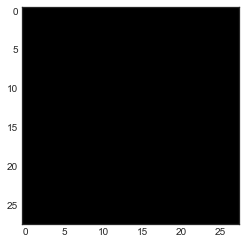

In [37]:
blank_imgs = np.zeros((1, 784)).reshape(28, 28)
plt.imshow(blank_imgs, interpolation=None, cmap=plt.cm.gray, vmin=0, vmax=1)
plt.show()

In [38]:

def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Filter ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest", cmap="gray")

def getActivations(layer,stimuli):
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,784],order='F'),keep_prob:1.0})
    plotNNFilter(units)


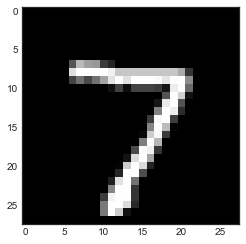

In [39]:
imageToUse = mnist.test.images[0]
plt.imshow(np.reshape(imageToUse,[28,28]), interpolation="nearest", cmap="gray")

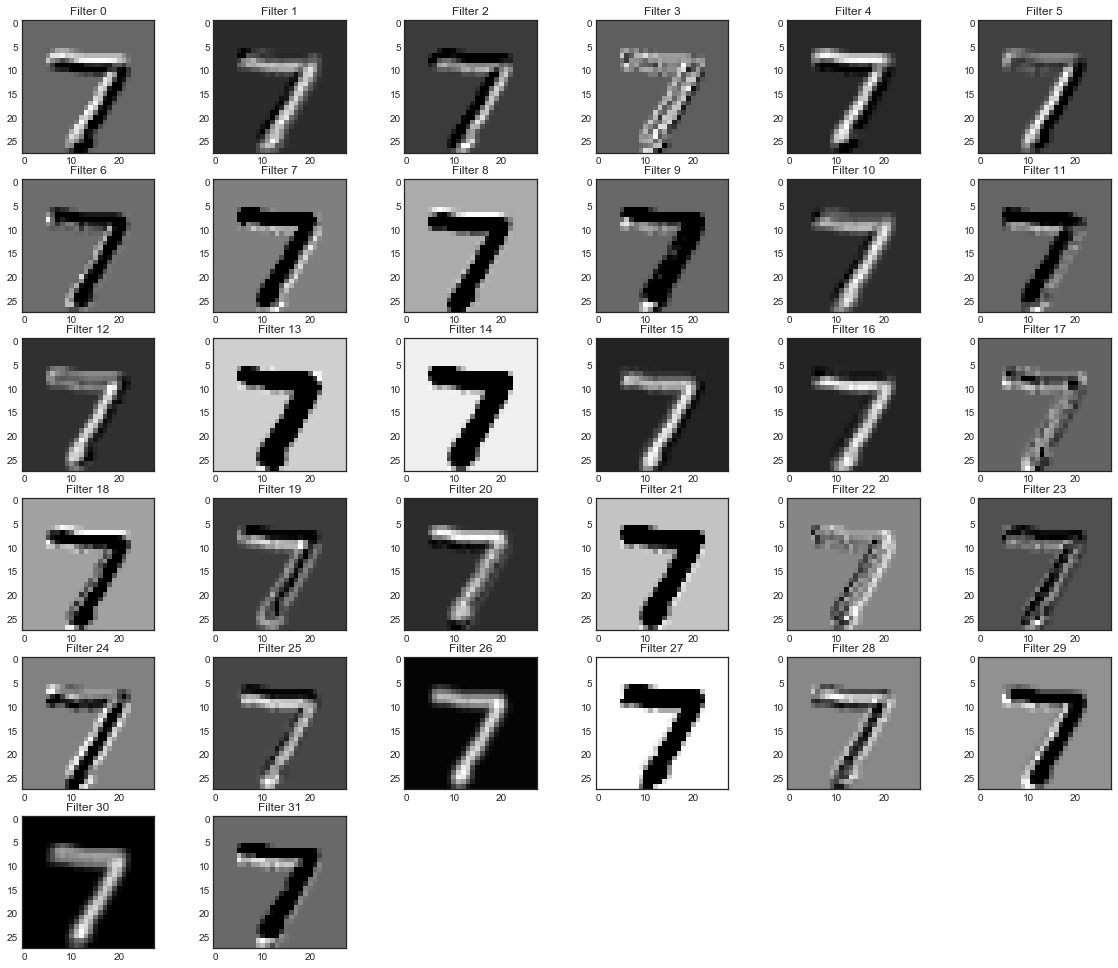

In [35]:
getActivations(x_conv1,imageToUse)

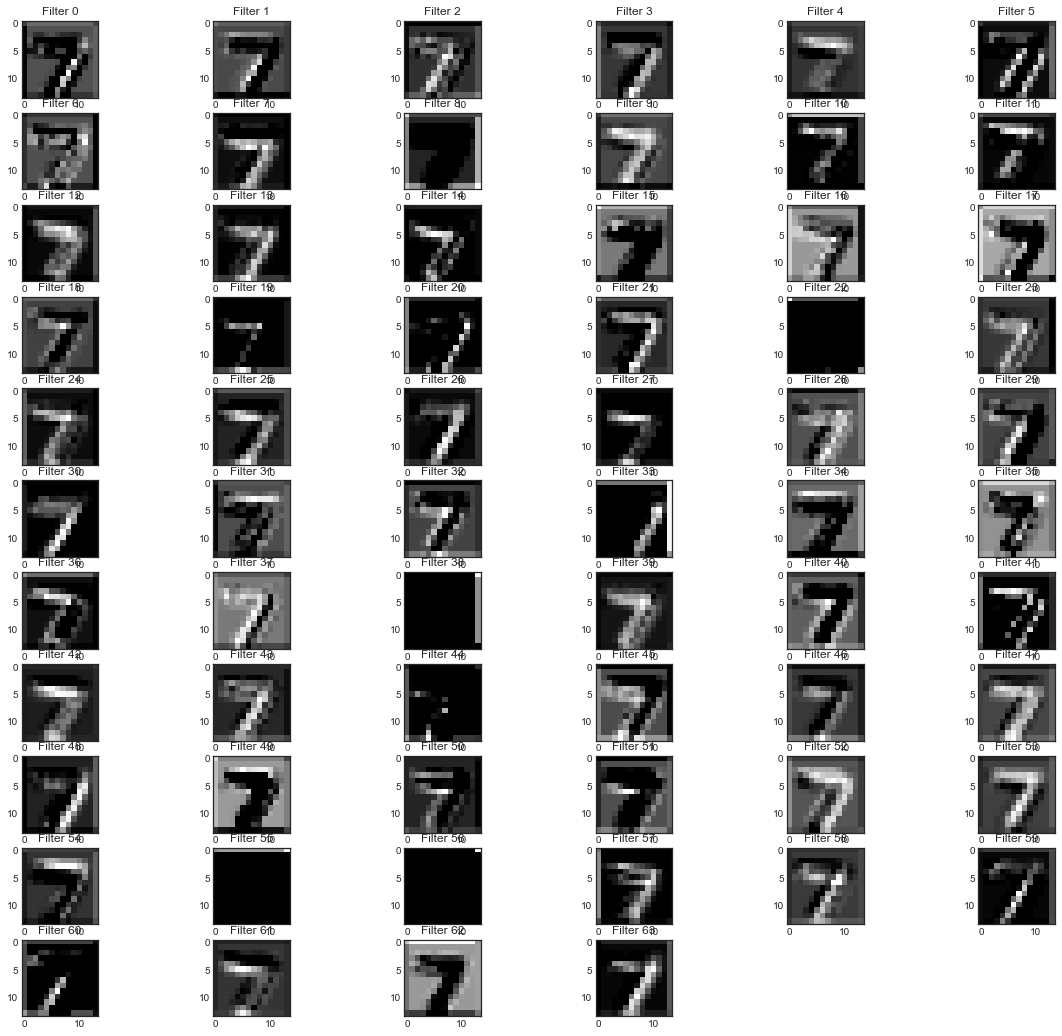

In [36]:
getActivations(x_conv2,imageToUse)